<a href="https://colab.research.google.com/github/Siddhi-Sovle/Grammer_Scoring_Engine/blob/main/Grammer_Scoring_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers torchaudio soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# HuggingFace and PyTorch
from transformers import HubertModel
import torchaudio
import torch

# Data & Math
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Joblib for saving model
import joblib

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Loading model
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
hubert_model.eval().cuda()


# Audio loader
def load_audio(file_path, target_sr=16000):
    waveform, sr = torchaudio.load(file_path)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
    return waveform.squeeze()

@torch.no_grad()
def extract_hubert_embedding(audio_tensor):
    if audio_tensor.dim() > 1:
        audio_tensor = audio_tensor[0]
    input_values = audio_tensor.unsqueeze(0).cuda()
    outputs = hubert_model(input_values)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu()

# Paths
AUDIO_DIR = "/content/drive/MyDrive/audios_train"
EMB_DIR = "/content/hubert_embeddings_train/"
os.makedirs(EMB_DIR, exist_ok=True)

# Extracting and saving embeddings
for file_name in tqdm(os.listdir(AUDIO_DIR)):
    if not file_name.endswith(".wav"):
        continue
    audio_path = os.path.join(AUDIO_DIR, file_name)
    emb_path = os.path.join(EMB_DIR, file_name.replace(".wav", ".npy"))

    audio_tensor = load_audio(audio_path)
    embedding = extract_hubert_embedding(audio_tensor)
    np.save(emb_path, embedding.numpy())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]


100%|██████████| 444/444 [05:20<00:00,  1.39it/s]




*   Preparing X and y cleanly from stored embeddings.
*   Handles missing files gracefully.



In [19]:
import pandas as pd
import numpy as np

# Load labels CSV
labels_df = pd.read_csv("/content/train.csv")  # Must have 'filename' and 'label' columns

# Load embeddings and match with labels
def load_features_and_labels(embedding_dir, labels_df):
    X, y = [], []
    for row in labels_df.itertuples():
        emb_path = os.path.join(embedding_dir, row.filename.replace(".wav", ".npy"))
        if os.path.exists(emb_path):
            X.append(np.load(emb_path))
            y.append(row.label)
        else:
            print(f"⚠️ Missing embedding for {row.filename}")
    return np.array(X), np.array(y)


✅ Loaded 444 training samples


In [25]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# # Train model
# model = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, gamma="scale"))
# model.fit(X_train, y_train)

# # Save model
# joblib.dump(model, "/content/svr_grammar_model.pkl")
# print("✅ SVR model saved.")

X, y = load_features_and_labels("/content/hubert_embeddings_train", labels_df)

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Loaded {len(X_train)} training and {len(X_val)} validation samples")

# Train SVR model
model = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, gamma="scale"))
model.fit(X_train, y_train)
print("✅ Model trained")

# Predict on validation
y_pred = model.predict(X_val)

# Evaluate
pearson_corr, _ = pearsonr(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📉 MAE: {mae:.4f}")
print(f"📉 RMSE: {rmse:.4f}")
print(f"🧠 R² Score: {r2:.4f}")


✅ Loaded 355 training and 89 validation samples
✅ Model trained
📈 Pearson Correlation: 0.8112
📉 MAE: 0.5440
📉 RMSE: 0.6962
🧠 R² Score: 0.6444


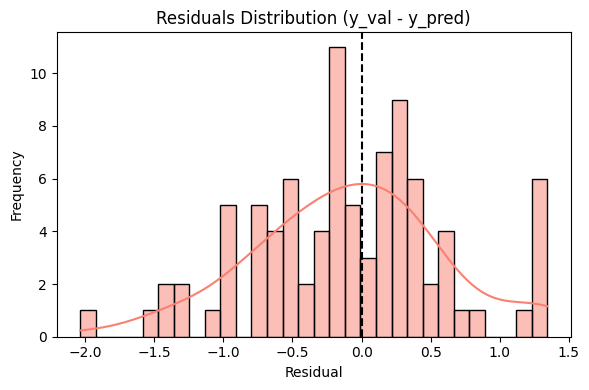

In [31]:
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, color='salmon')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residuals Distribution (y_val - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


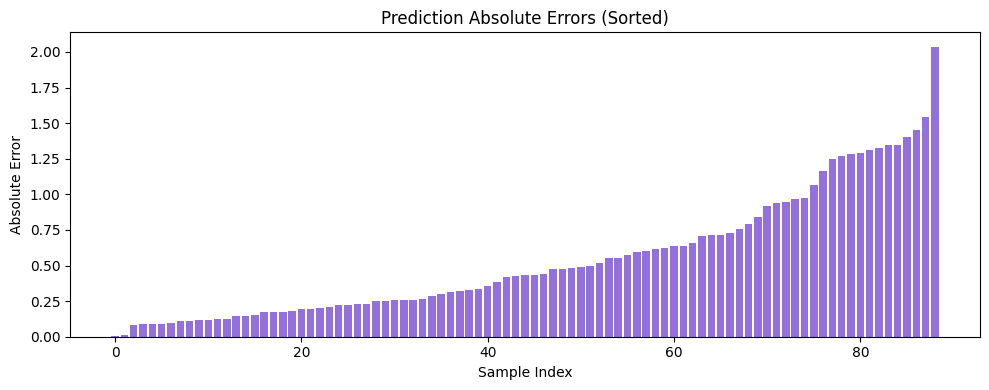

In [29]:
errors = np.abs(y_val - y_pred)
sorted_idx = np.argsort(errors)

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(errors)), errors[sorted_idx], color='mediumpurple')
plt.title("Prediction Absolute Errors (Sorted)")
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.tight_layout()
plt.show()


<ipython-input-30-1c59d1798369>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette=colors)


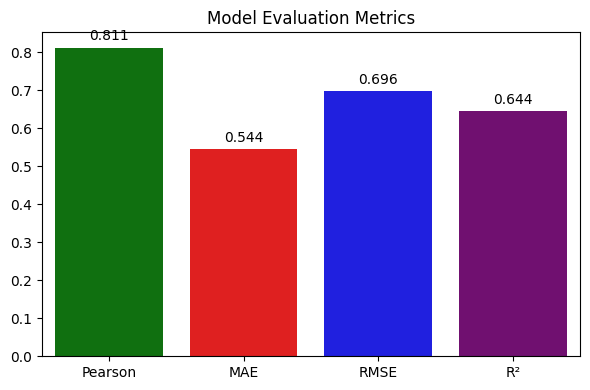

In [30]:
plt.figure(figsize=(6,4))
metrics = [pearson_corr, mae, rmse, r2]
names = ['Pearson', 'MAE', 'RMSE', 'R²']
colors = ['green', 'red', 'blue', 'purple']

sns.barplot(x=names, y=metrics, palette=colors)
plt.title("Model Evaluation Metrics")
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()


In [21]:
# Load test.csv
test_df = pd.read_csv("/content/test.csv")  # Contains only 'filename'

TEST_EMB_DIR = "/content/hubert_embeddings_test"

# Load embeddings in the same order as test_df
X_test = [np.load(os.path.join(TEST_EMB_DIR, f.replace(".wav", ".npy"))) for f in test_df['filename']]
X_test = np.array(X_test)

# Predict
y_pred = model.predict(X_test)

# Add predictions to test_df
test_df['label'] = y_pred

# Save as submission
test_df.to_csv("submission_pleasehoja.csv", index=False)
print("✅ Submission file saved correctly")


✅ Submission file saved correctly
